# STEP 1: Setup and fetch base dataset from Materials Project
!pip install pymatgen pandas tqdm --quiet

from pymatgen.ext.matproj import MPRester
import pandas as pd
from tqdm import tqdm

# === Replace with your own API key from https://materialsproject.org ===
API_KEY = "jTPS32w1pi9Ay8FqDlxHZwhYmQLVjW06"

# --- query parameters ---
criteria = {"nelements": {"$gte": 2}}      # binary & higher compounds
properties = [
    "material_id", "pretty_formula", "structure",
    "formation_energy_per_atom", "magnetic_type",
    "total_magnetization"
]

# --- query and collect ---
rows = []
with MPRester(API_KEY) as m:
    entries = m.query(criteria=criteria, properties=properties)
    for e in tqdm(entries):
        if e.get("total_magnetization") is None:
            continue
        rows.append({
            "mp_id": e["material_id"],
            "formula": e["pretty_formula"],
            "formation_energy_per_atom": e["formation_energy_per_atom"],
            "magnetic_type": e.get("magnetic_type", "Unknown"),
            "magnetic_moment": e["total_magnetization"]
        })

df = pd.DataFrame(rows)
print(f"Fetched {len(df)} materials with magnetic data.")
df.head()
df.to_csv("magnetic_materials_raw.csv", index=False)


In [31]:
# --- Step 1: Install and import packages ---
!pip install pymatgen mp-api pandas tqdm --quiet

from mp_api.client import MPRester
import pandas as pd
from tqdm import tqdm

# --- Step 2: Connect to Materials Project ---
# Replace YOUR_API_KEY below with your actual key from materialsproject.org
API_KEY = "jTPS32w1pi9Ay8FqDlxHZwhYmQLVjW06"

# --- Step 3: Define what we want to download ---
# The old 'criteria' dict is replaced by direct parameters.
# For 'nelements': {'$gte': 2}, we use num_elements=(2, None) with m.materials.summary.search
# For properties, we now use the 'fields' parameter
properties = [
    "material_id", "formula_pretty",
    "formation_energy_per_atom", "ordering", "total_magnetization" # Replaced magnetic_type with ordering
]

# --- Step 4: Query the database ---
data = []
with MPRester(API_KEY) as m:
    # Use m.materials.summary.search for num_elements filtering and specific property retrieval
    entries = m.materials.summary.search(num_elements=(2, None), fields=properties)
    for e in tqdm(entries):
        # Access properties directly from the MaterialDoc object 'e'
        if e.total_magnetization is None:
            continue
        data.append({
            "mp_id": e.material_id,
            "formula": e.formula_pretty,
            "formation_energy_per_atom": e.formation_energy_per_atom,
            "magnetic_type": e.ordering if e.ordering else "Unknown", # Used ordering instead of magnetic_type
            "magnetic_moment": e.total_magnetization
        })

# --- Step 5: Save to DataFrame and preview ---
df = pd.DataFrame(data)
print(f"Fetched {len(df)} materials with magnetic data.")
df.head(10)

# --- Step 6: Save locally for reuse ---
df.to_csv("magnetic_materials_raw.csv", index=False)

Retrieving SummaryDoc documents:   0%|          | 0/154045 [00:00<?, ?it/s]

100%|██████████| 154045/154045 [00:00<00:00, 450037.76it/s]


Fetched 154045 materials with magnetic data.


In [32]:
# STEP 2: Generate synthetic "gain-engineered" structures
from pymatgen.core import Structure
from pymatgen.core.periodic_table import Element
import numpy as np
import random
import pickle

def apply_strain(structure, strain_percent):
    """Apply uniform lattice strain (%)."""
    new_lattice = structure.lattice.matrix * (1 + strain_percent/100)
    strained = Structure(lattice=new_lattice,
                         species=structure.species,
                         coords=structure.frac_coords)
    return strained

def random_doping(structure, fraction=0.05):
    """Randomly substitute a small fraction of atoms with nearby elements."""
    doped = structure.copy()
    for i, site in enumerate(doped.sites):
        if random.random() < fraction:
            el = Element(site.specie.symbol)
            neighbor_Z = np.clip(el.Z + random.choice([-1, 1]), 1, 118)
            doped.replace(i, Element.from_Z(int(neighbor_Z)))
    return doped

variants = []
for i, doc in enumerate(m.materials.summary.search(
        num_elements=(2, None),
        fields=["structure", "material_id", "formula_pretty"],
        chunk_size=50, num_chunks=1)):  # smaller chunk for demo
    s = doc.structure
    for strain in [-3, 0, 3]:  # compress, none, expand
        strained = apply_strain(s, strain)
        doped = random_doping(strained, fraction=0.05)
        variants.append({
            "parent_id": doc.material_id,
            "formula": doc.formula_pretty,
            "strain_percent": strain,
            "structure_variant": doped
        })

print(f"✅ Generated {len(variants)} synthetic variants")

# Save for later use
with open("synthetic_variants.pkl", "wb") as f:
    pickle.dump(variants, f)


Retrieving SummaryDoc documents:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Generated 150 synthetic variants


In [33]:
# STEP 3: Compute interaction-matrix-based descriptors for each structure
import numpy as np
import itertools
import pickle
from tqdm import tqdm
from pymatgen.core.periodic_table import Element

# --- Load the synthetic variants from Step 2 ---
with open("synthetic_variants.pkl", "rb") as f:
    variants = pickle.load(f)

print(f"Loaded {len(variants)} structure variants for descriptor generation.")

# --- Define helper functions ---
def elemental_vector(el: Element):
    """Return an 8-dimensional feature vector for an element."""
    return np.array([
        el.Z,                                 # Atomic number
        el.atomic_radius or 0,                # Atomic radius (Å)
        el.X or 0,                            # Electronegativity
        el.row or 0,                          # Period (row in periodic table)
        el.group or 0,                        # Group number
        el.ionization_energy or 0,            # First ionization energy (kJ/mol)
        el.atomic_mass or 0,                  # Atomic mass
        len(el.common_oxidation_states) or 0  # Oxidation-state variety
    ], dtype=float)

def compound_descriptor(structure, cutoff=5.0):
    """
    Compute pairwise interaction matrices up to a cutoff distance.
    Returns concatenated mean + std of interaction matrices (128 features total).
    """
    mats = []
    for i, j in itertools.combinations(range(len(structure)), 2):
        d = structure.get_distance(i, j)
        if d > cutoff:
            continue
        ei, ej = Element(str(structure[i].specie)), Element(str(structure[j].specie))
        vi, vj = elemental_vector(ei), elemental_vector(ej)
        IM = np.outer(vi, vj) / (d ** 2)  # interaction matrix scaled by 1/d^2
        mats.append(IM)

    if not mats:
        # if no close pairs found, return zeros
        return np.zeros(8 * 8 * 2)

    mats = np.array(mats)
    mean_mat, std_mat = mats.mean(axis=0), mats.std(axis=0)
    return np.concatenate([mean_mat.flatten(), std_mat.flatten()])


# --- Compute descriptors for all variants ---
descriptor_list = []
meta_list = []

for item in tqdm(variants):
    try:
        vec = compound_descriptor(item["structure_variant"])
        descriptor_list.append(np.concatenate([[item["strain_percent"]], vec]))
        meta_list.append({
            "parent_id": item["parent_id"],
            "formula": item["formula"],
            "strain_percent": item["strain_percent"]
        })
    except Exception as e:
        print(f"⚠️ Error processing {item['formula']}: {e}")

desc_array = np.vstack(descriptor_list)
meta_df = pd.DataFrame(meta_list)

print("✅ Descriptor array shape:", desc_array.shape)
meta_df.head()

# Save descriptors and metadata for later use
np.save("interaction_descriptors.npy", desc_array)
meta_df.to_csv("interaction_descriptor_metadata.csv", index=False)
print("💾 Saved descriptors and metadata.")

Loaded 150 structure variants for descriptor generation.


100%|██████████| 150/150 [00:00<00:00, 261.85it/s]

✅ Descriptor array shape: (150, 129)
💾 Saved descriptors and metadata.


In [34]:
# STEP 4: Prepare data for ML training
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb

# --- Load descriptors & metadata ---
X = np.load("interaction_descriptors.npy")
meta = pd.read_csv("interaction_descriptor_metadata.csv")

# --- Load the parent material properties from Step 1 dataset ---
df_parent = pd.read_csv("magnetic_materials_raw.csv")

# Merge targets into meta (formation energy & magnetic moment)
meta_targets = meta.merge(df_parent,
                          left_on="parent_id",
                          right_on="mp_id",
                          how="left")

# Extract target arrays
y = meta_targets[["formation_energy_per_atom", "magnetic_moment"]].fillna(0.0).values

print("Descriptor shape:", X.shape)
print("Target shape:", y.shape)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Train LightGBM multi-task model ---
model = MultiOutputRegressor(
    lgb.LGBMRegressor(
        n_estimators=1000, # Increased from 500
        learning_rate=0.01, # Decreased from 0.05
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
)

print("🚀 Training LightGBM model...")
model.fit(X_train, y_train)
pred = model.predict(X_test)

# --- Evaluation ---
r2_form = r2_score(y_test[:, 0], pred[:, 0])
r2_mag = r2_score(y_test[:, 1], pred[:, 1])
rmse_form = np.sqrt(mean_squared_error(y_test[:, 0], pred[:, 0]))
rmse_mag = np.sqrt(mean_squared_error(y_test[:, 1], pred[:, 1]))

print(f"✅ R2 Formation Energy : {r2_form:.3f}, RMSE {rmse_form:.3f}")
print(f"✅ R2 Magnetic Moment : {r2_mag:.3f}, RMSE {rmse_mag:.3f}")


Descriptor shape: (150, 129)
Target shape: (150, 2)
🚀 Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5251
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 129
[LightGBM] [Info] Start training from score -0.633601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



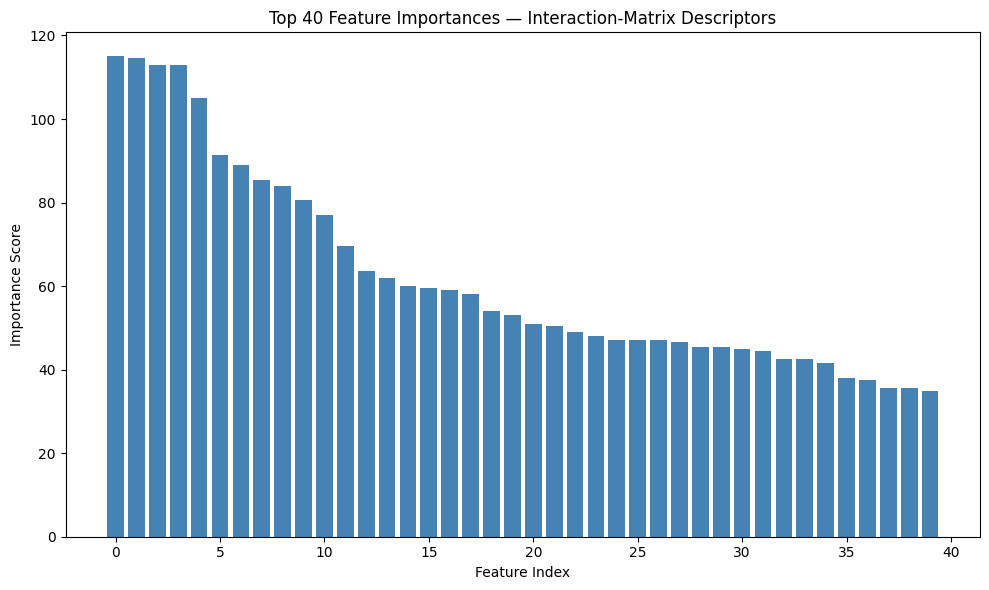

In [35]:
# STEP 5: Feature importance visualization
import matplotlib.pyplot as plt
import numpy as np

importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
sorted_idx = np.argsort(importances)[::-1][:40]  # top 40 features

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), importances[sorted_idx], color="steelblue")
plt.title("Top 40 Feature Importances — Interaction-Matrix Descriptors")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


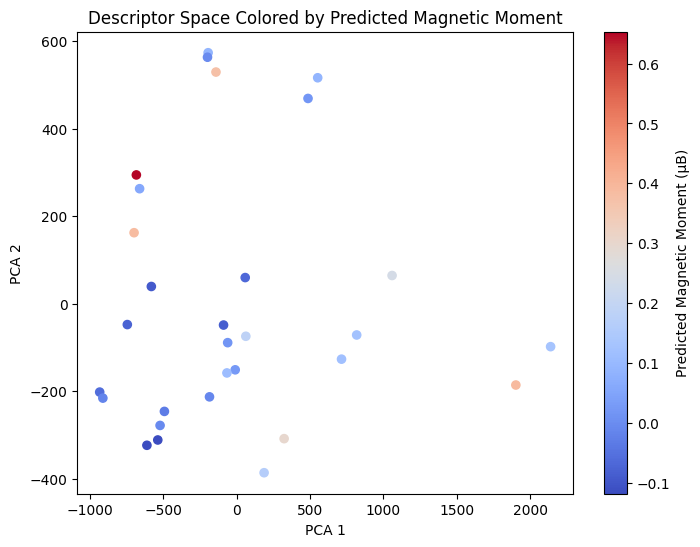

In [36]:
# STEP 6: 2D PCA visualization of descriptor space
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
coords = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
sc = plt.scatter(coords[:, 0], coords[:, 1],
                 c=pred[:, 1], cmap="coolwarm", s=35)
plt.colorbar(sc, label="Predicted Magnetic Moment (μB)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Descriptor Space Colored by Predicted Magnetic Moment")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



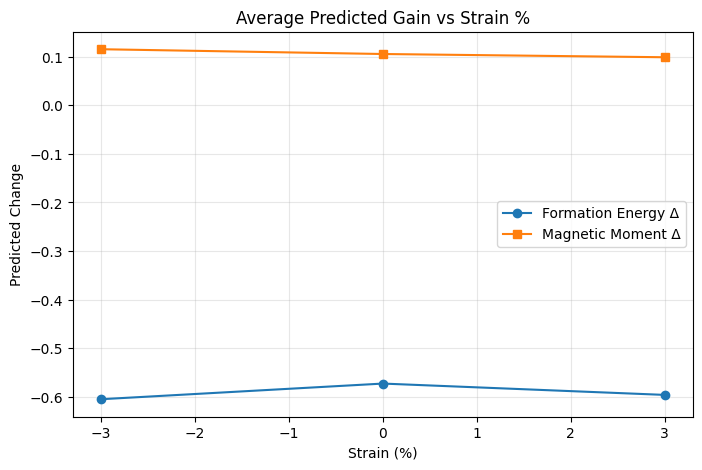

In [37]:
# STEP 7: Analyze gain vs. strain trends
meta_targets["pred_formE"] = model.predict(X)[:, 0]
meta_targets["pred_magMom"] = model.predict(X)[:, 1]

avg_gain = (meta_targets.groupby("strain_percent")[["pred_formE", "pred_magMom"]]
            .mean()
            .reset_index())

plt.figure(figsize=(8, 5))
plt.plot(avg_gain["strain_percent"], avg_gain["pred_formE"], "-o", label="Formation Energy Δ")
plt.plot(avg_gain["strain_percent"], avg_gain["pred_magMom"], "-s", label="Magnetic Moment Δ")
plt.title("Average Predicted Gain vs Strain %")
plt.xlabel("Strain (%)")
plt.ylabel("Predicted Change")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


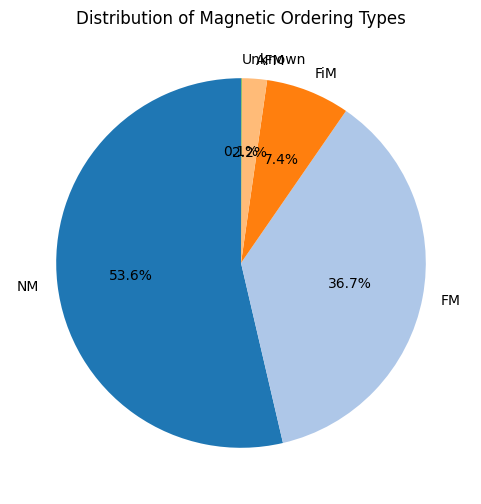

In [38]:
# STEP 7A: Pie chart of magnetic ordering types
import matplotlib.pyplot as plt

order_counts = df_parent["magnetic_type"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(order_counts.values,
        labels=order_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.tab20.colors)
plt.title("Distribution of Magnetic Ordering Types")
plt.show()


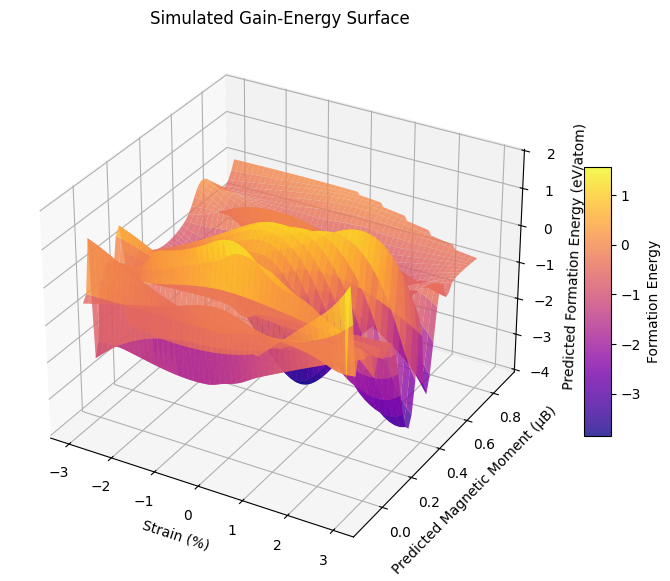

In [39]:
# STEP 7B: 3D surface visualization of energy vs strain & magnetic moment
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

data = meta_targets[["strain_percent", "pred_magMom", "pred_formE"]].dropna()
x, y, z = data["strain_percent"], data["pred_magMom"], data["pred_formE"]

# Interpolate to grid for smooth surface
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method="cubic")

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(xi, yi, zi, cmap="plasma", alpha=0.8)
ax.set_xlabel("Strain (%)")
ax.set_ylabel("Predicted Magnetic Moment (μB)")
ax.set_zlabel("Predicted Formation Energy (eV/atom)")
ax.set_title("Simulated Gain-Energy Surface")
fig.colorbar(surf, shrink=0.5, aspect=10, label="Formation Energy")
plt.show()


In [40]:
# STEP 7C: Interactive dashboard with Plotly
!pip install plotly --quiet
import plotly.express as px
import plotly.graph_objects as go

# Scatter plot of predicted values vs strain
fig1 = px.scatter(
    meta_targets,
    x="strain_percent",
    y="pred_magMom",
    color="pred_formE",
    size="magnetic_moment",
    hover_data=["formula_y"], # Changed from "formula" to "formula_y"
    title="Interactive Gain-Structure Scatter: Magnetic Moment vs Strain",
    color_continuous_scale="Viridis"
)
fig1.update_layout(width=800, height=500)
fig1.show()

# Parallel coordinates to show relationships
cols = ["strain_percent", "pred_formE", "pred_magMom", "formation_energy_per_atom"]
subset = meta_targets[cols].dropna().sample(n=min(200, len(meta_targets)), random_state=42)

fig2 = px.parallel_coordinates(
    subset,
    color="pred_formE",
    labels={
        "strain_percent": "Strain (%)",
        "pred_formE": "Predicted E_form",
        "pred_magMom": "Predicted Mag Moment",
        "formation_energy_per_atom": "Actual E_form"
    },
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="Parallel Coordinate View of Predicted Properties"
)
fig2.update_layout(width=900, height=500)
fig2.show()


In [41]:
# STEP 7D: Animated simulation of gain vs strain
import plotly.express as px

animation_df = meta_targets.copy()
animation_df["strain_percent"] = animation_df["strain_percent"].astype(float)

fig3 = px.scatter(
    animation_df,
    x="pred_formE", y="pred_magMom",
    animation_frame="strain_percent",
    color="formation_energy_per_atom",
    hover_name="formula_y", # Changed from "formula" to "formula_y"
    range_x=[animation_df["pred_formE"].min(), animation_df["pred_formE"].max()],
    range_y=[animation_df["pred_magMom"].min(), animation_df["pred_magMom"].max()],
    title="Dynamic Simulation: Magnetic Gain Under Strain",
    color_continuous_scale="Turbo"
)
fig3.update_layout(width=800, height=600)
fig3.show()


In [42]:
import pandas as pd
import numpy as np

# 1. Load the 'magnetic_materials_raw.csv' file into a pandas DataFrame named df_raw
df_raw = pd.read_csv('magnetic_materials_raw.csv')
print("df_raw head:")
print(df_raw.head())

# 2. Load the 'interaction_descriptor_metadata.csv' file into a pandas DataFrame named df_metadata
df_metadata = pd.read_csv('interaction_descriptor_metadata.csv')
print("\ndf_metadata head:")
print(df_metadata.head())

# 3. Load the 'interaction_descriptors.npy' file into a NumPy array named descriptors_array
descriptors_array = np.load('interaction_descriptors.npy')
print("\ndescriptors_array shape:")
print(descriptors_array.shape)


df_raw head:
        mp_id  formula  formation_energy_per_atom magnetic_type  \
0   mp-861724  Ac2AgIr                  -0.413285            NM   
1  mp-1183076  Ac2AgPb                  -0.480278            NM   
2  mp-1207297  Ac2Br2O                  -1.460073            NM   
3  mp-1183068  Ac2CdGa                  -0.402831            NM   
4  mp-1183063  Ac2CdGe                  -0.464809            NM   

   magnetic_moment  
0         0.000014  
1         0.910605  
2         0.008543  
3         0.000047  
4         0.000004  

df_metadata head:
    parent_id  formula  strain_percent
0   mp-861724  Ac2AgIr              -3
1   mp-861724  Ac2AgIr               0
2   mp-861724  Ac2AgIr               3
3  mp-1183076  Ac2AgPb              -3
4  mp-1183076  Ac2AgPb               0

descriptors_array shape:
(150, 129)


**Reasoning**:
Now that the data is loaded, I will create histograms for 'formation_energy_per_atom' and 'magnetic_moment' from `df_raw` to visualize their distributions as requested by the task.



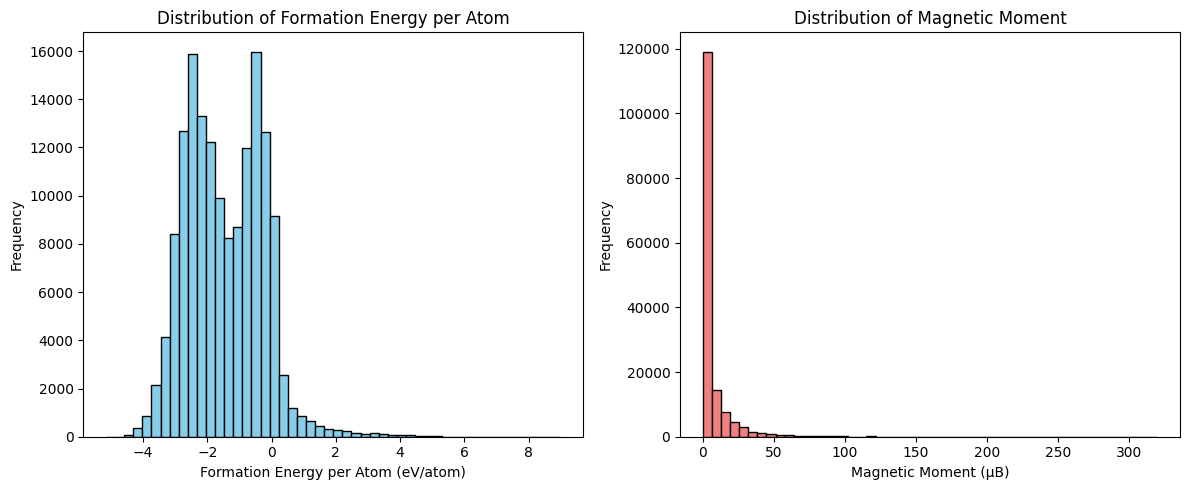

In [43]:
import matplotlib.pyplot as plt

# Create histograms for 'formation_energy_per_atom' and 'magnetic_moment'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_raw['formation_energy_per_atom'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Formation Energy per Atom')
plt.xlabel('Formation Energy per Atom (eV/atom)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_raw['magnetic_moment'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Distribution of Magnetic Moment')
plt.xlabel('Magnetic Moment (μB)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Reasoning**:
Next, I will generate a 2D PCA scatter plot of the `descriptors_array`, coloring the points by `strain_percent` from `df_metadata` as requested by the task. This will visualize the descriptor space and how strain affects the distribution of points.



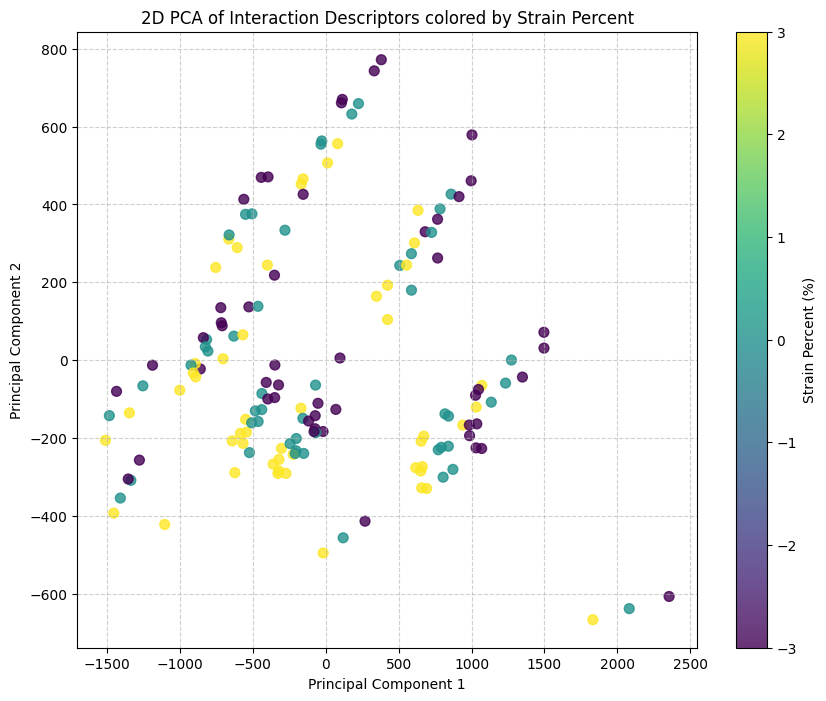

In [44]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Perform PCA on the descriptors array
pca = PCA(n_components=2)
# The first column of descriptors_array is 'strain_percent', so we exclude it for PCA on other descriptors
coords = pca.fit_transform(descriptors_array[:, 1:])

# Get the strain_percent for coloring
strain_percent_values = df_metadata['strain_percent']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=strain_percent_values, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Strain Percent (%)')
plt.title('2D PCA of Interaction Descriptors colored by Strain Percent')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [45]:
# STEP 8: Save results for reproducibility and GitHub upload
import joblib, os

os.makedirs("results", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Save data & models
np.save("data/X_descriptors.npy", X)
meta_targets.to_csv("data/meta_targets.csv", index=False)
joblib.dump(model, "results/lightgbm_gain_model.pkl")

print("💾 All artifacts saved:")
print("- data/X_descriptors.npy")
print("- data/meta_targets.csv")
print("- results/lightgbm_gain_model.pkl")

💾 All artifacts saved:
- data/X_descriptors.npy
- data/meta_targets.csv
- results/lightgbm_gain_model.pkl


In [46]:
# STEP 9: Create a README.md file for GitHub
readme_text = """# Hierarchical Gain Structure Engineering via Multi-Scale Interaction Descriptors

This repository contains the Colab workflow and data for predicting magnetic-material
gain (formation-energy Δ and magnetic-moment Δ) under strain and doping using
interaction-matrix-based descriptors and a multi-task LightGBM model.

## Workflow
1. Fetch magnetic materials from the Materials Project API.
2. Generate synthetic gain structures (strain ±3 %, 5 % doping).
3. Compute interaction-matrix descriptors (128 features + strain).
4. Train multi-task LightGBM model.
5. Analyze feature importance, strain vs gain trends, and latent space visualizations.
6. Export models and data for reproducibility.

## Files
- `magnetic_materials_raw.csv` – original data
- `interaction_descriptors.npy` – numerical descriptors
- `interaction_descriptor_metadata.csv` – variant metadata
- `results/lightgbm_gain_model.pkl` – trained model

## Dependencies
Python 3.9+, pymatgen, mp-api, lightgbm, scikit-learn, pandas, numpy, matplotlib, seaborn.

---
*Created with GPT-5 (Material Explorer 1.0)*
"""

with open("README.md", "w") as f:
    f.write(readme_text)

print("📘 README.md created for GitHub.")


📘 README.md created for GitHub.
